# HT-MEK Data Processing Workbook
Author: Micah Olivas

In [1]:
# This will autoreload imported modules
%load_ext autoreload
%autoreload 2

# Import modules
from experiment_processing import processing

# Set up parallel processing
from pandarallel import pandarallel
processing.pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Import kinetic and standard series data

Read raw kinetic and standards data with Pandas

In [2]:
# csv of kinetic data from processing notebook
kinetic_data_path = '/Volumes/Micah_Data/HT-MEK_data/ACYP/230415_SFL_ACYPs/Assays/AcP/d2_TitrationSeries_Analysis.csv.bz2'

# csv of standard data from processing notebook
standard_data_path = '/Volumes/Micah_Data/HT-MEK_data/ACYP/230415_SFL_ACYPs/Standards/Analysis/d2_pbp_StandardSeries_Analysis.csv.bz2'

# csv of egfp data from processing notebook
egfp_data_path = '/Volumes/Micah_Data/HT-MEK_data/ACYP/230415_SFL_ACYPs/egfp/StitchedImagesGFP_Summary.csv.bz2'

# path to egfp summary image for image segmentation and manual chamber culling
egfp_button_summary_image_path = '/Volumes/Micah_Data/HT-MEK_data/ACYP/230415_SFL_ACYPs/egfp/20230416-193203-d2_egfp_post_binding_quant/egfp/StitchedImages/SummaryImages/Summary_StitchedImg_100_egfp_0.tif'

# path to the folder where you want to save the exported data
export_path_root = "/Volumes/Micah_Data/HT-MEK_data/ACYP/230415_SFL_ACYPs/Interpretation"



# experiment information
experimental_day = '230419'
experiment_name = 'AcyP_SFL_203'
setup = 'S2'
device = 'd2'
egfp_slope = 188847
substrate = 'AcP'
pbp_conc = 30
all_substrate_concs = [10, 25, 50, 75, 100]
device_columns = 32
device_rows = 56



# Create dataframes for kinetic and standard series
kinetic_data = processing.pd.read_csv(kinetic_data_path)
standard_data = processing.pd.read_csv(standard_data_path)
egfp_data = processing.pd.read_csv(egfp_data_path)
standard_data = standard_data.dropna()
export_path_root = export_path_root + '/' + substrate


# Print kinetic data head
kinetic_data.head()

,x,y,median_chamber,sum_chamber,std_chamber,x_center_chamber,y_center_chamber,radius_chamber,xslice,yslice,...,radius_button_disk_Button_Quant,median_button_annulus_Button_Quant,summed_button_annulus_normed_Button_Quant,std_button_annulus_localBG_Button_Quant,inner_radius_button_annulus_Button_Quant,outer_radius_button_annulus_Button_Quant,xslice_Button_Quant,yslice_Button_Quant,id_Button_Quant,series_index
0,1,1,7769,25187243,1523,49,41,33,"(392, 492)","(442, 542)",...,15,5951,4220914,126,15,15,"(392, 492)","(442, 542)",1C8_phorikoshii_pross_2,10uM_AcP_d2
1,1,1,10842,34589616,2367,49,41,33,"(392, 492)","(442, 542)",...,15,5951,4220914,126,15,15,"(392, 492)","(442, 542)",1C8_phorikoshii_pross_2,10uM_AcP_d2
2,1,1,14639,45162985,3969,49,41,33,"(392, 492)","(442, 542)",...,15,5951,4220914,126,15,15,"(392, 492)","(442, 542)",1C8_phorikoshii_pross_2,10uM_AcP_d2
3,1,1,11385,36203878,2540,49,41,33,"(392, 492)","(442, 542)",...,15,5951,4220914,126,15,15,"(392, 492)","(442, 542)",1C8_phorikoshii_pross_2,10uM_AcP_d2
4,1,1,9020,28968592,1845,49,41,33,"(392, 492)","(442, 542)",...,15,5951,4220914,126,15,15,"(392, 492)","(442, 542)",1C8_phorikoshii_pross_2,10uM_AcP_d2


**Development**: Extract assay data from series index; if you don't want to use this, comment out the next cell.

In [3]:
# use regex pattern to extract substrate and condition concentrations from the series_index string such as '25uM_ATP_1mM_EDTA'
tags = ['substrate_conc_uM', 'substrate']
series_index_pattern = r'(?P<%s>\d+)uM_(?P<%s>\w+)_' % (tags[0], tags[1])

# replace the sequence "no" in the series_index column with "0" to make it easier to convert to numeric
kinetic_data['series_index'] = kinetic_data['series_index'].str.replace('no', '0mM')

# apply regex pattern to each string in the "text" column and create new columns
kinetic_data['series_index'].str.extract(series_index_pattern)

# extract the new columns from the regex pattern and convert numeric columns to float
kinetic_data[tags] = kinetic_data['series_index'].str.extract(series_index_pattern)
kinetic_data[tags] = kinetic_data[tags].apply(processing.pd.to_numeric, errors='ignore')
kinetic_data.head()

,x,y,median_chamber,sum_chamber,std_chamber,x_center_chamber,y_center_chamber,radius_chamber,xslice,yslice,...,summed_button_annulus_normed_Button_Quant,std_button_annulus_localBG_Button_Quant,inner_radius_button_annulus_Button_Quant,outer_radius_button_annulus_Button_Quant,xslice_Button_Quant,yslice_Button_Quant,id_Button_Quant,series_index,substrate_conc_uM,substrate
0,1,1,7769,25187243,1523,49,41,33,"(392, 492)","(442, 542)",...,4220914,126,15,15,"(392, 492)","(442, 542)",1C8_phorikoshii_pross_2,10uM_AcP_d2,10,AcP
1,1,1,10842,34589616,2367,49,41,33,"(392, 492)","(442, 542)",...,4220914,126,15,15,"(392, 492)","(442, 542)",1C8_phorikoshii_pross_2,10uM_AcP_d2,10,AcP
2,1,1,14639,45162985,3969,49,41,33,"(392, 492)","(442, 542)",...,4220914,126,15,15,"(392, 492)","(442, 542)",1C8_phorikoshii_pross_2,10uM_AcP_d2,10,AcP
3,1,1,11385,36203878,2540,49,41,33,"(392, 492)","(442, 542)",...,4220914,126,15,15,"(392, 492)","(442, 542)",1C8_phorikoshii_pross_2,10uM_AcP_d2,10,AcP
4,1,1,9020,28968592,1845,49,41,33,"(392, 492)","(442, 542)",...,4220914,126,15,15,"(392, 492)","(442, 542)",1C8_phorikoshii_pross_2,10uM_AcP_d2,10,AcP


In [4]:
# Format all dataframes
standard_data, kinetic_data = processing.format_data(standard_data=standard_data, kinetic_data=kinetic_data, egfp_data=egfp_data)

## "Squeeze" DataFrames

At this point, our DataFrames are in a long format: each row of kinetic_data corresponds to an individual timepoint in the kinetic assays, while each row of standard_data corresponds to an individual standard concentration. To support vectorized curve fitting operations later, we want to flatten or "squeeze" rows of each DataFrame into series (e.g. time, intensity, standard concentration) by chamber.

In [5]:
kinetic_data['MutantID'] = kinetic_data['id'].astype(str)

In [6]:
squeeze_kinetics = processing.squeeze_kinetics(kinetic_data, additional_columns=[])

,x,y,Indices,MutantID,substrate,substrate_conc_uM,summed_button_BGsub_Button_Quant,time_s,kinetic_median_intensities
0,1,1,"01,01",1C8_phorikoshii_pross_2,AcP,10,5252210,"[0, 75, 150, 225, 300, 375, 450, 525, 600, 675...","[6067, 6962, 7769, 8401, 9020, 9531, 9953, 102..."
1,1,1,"01,01",1C8_phorikoshii_pross_2,AcP,25,5252210,"[0, 75, 150, 225, 300, 375, 450, 525, 600, 675...","[8317, 10125, 11456, 12688, 13702, 14582, 1532..."


"Squeeze" standard data to serialize standard concetrations. Plot representative standard curves

,x,y,Indices,standard_concentration_uM,standard_median_intensities
0,1,1,"01,01","[1, 3, 6, 15, 30, 75]","[2568, 15498, 12956, 20596, 23836, 24427]"
1,1,2,"01,02","[1, 3, 6, 15, 30, 75]","[3641, 15630, 13374, 20982, 24458, 25124]"
2,1,3,"01,03","[1, 3, 6, 15, 30, 75]","[4721, 15659, 13648, 21141, 24649, 25307]"
3,1,4,"01,04","[1, 3, 6, 15, 30, 75]","[6231, 14957, 13297, 20228, 23503, 24236]"


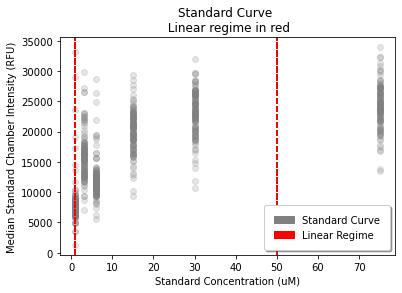

In [7]:
squeeze_standards = processing.squeeze_standard(standard_data)

## Calculate enzyme concentration from eGFP fluorescence

In [8]:
squeeze_kinetics['EnzymeConc'] = squeeze_kinetics['summed_button_BGsub_Button_Quant']/egfp_slope

## Fit PBP Standard Curves

To fit the PBP standard curve, we need to optimize a nonlinear least squares fit based on the following single-site binding isotherm for the phosphate sensor:

$I([Pi]) = 0.5A(KD +[Pi]+[PS]-\sqrt{(KD +[PS]+[Pi])^2 - 4[PS][Pi]}) + I(0μM)$

where $I([Pi])$ is the median fluorescence at a given $[Pi]$, $[PS]$ is the concentration of PBP, $K_D$ is the dissociation constant of Pi from PBP, $A$ is the scaling factor necessary to relate fraction PBP bound to observed fluorescence, and $I(0μM[Pi])$ is the median fluorescence intensity of PBP in the absence of added Pi.

To find product concentrations from measured intensities, we need to invert this isotherm. For this, we use the package `sympy`, which has a nice suite of tools for symbolic math.

In [9]:
# A, KD, P_i, PS, I_0uMP_i, I_P_i = symbols('A KD P_i PS I_0uMP_i I_P_i')

# isotherm_inverse = solve(0.5 * A * (KD + P_i + PS - ((KD + PS + P_i)**2 - 4*PS*P_i)**(1/2)) + I_0uMP_i - I_P_i, P_i)
# print('Inverse of isotherm:', isotherm_inverse)

If we would like to fit the inverse, we can simply copy this function into the following cell to perform the nonlinear least squares fit. Instead, we will densely interpolate the curve fits for each chamber and use the interpolations to approximate `[Pi]` concentration. The following function optimizes a least squares fit for each standard curve in each chamber and stores the optimum paramters as a list [`A, KD, PS, I_0uMP_i`] in the column `standard_popt`.

Now, let's check a few of the curve fits to make sure they look appropriate

Performing curve fits...
Some curve fits may fail, this is expected and will be replaced with NaNs


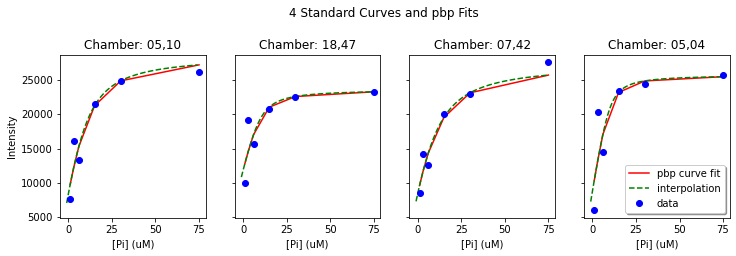

In [10]:
squeeze_standards = processing.standard_curve_fit(squeeze_standards, standard_type='pbp')

## Merge dataframes

Next we merge the standard and kinetic data on the chamber Indices and substrate columns and convert the kinetic median intensities to product concentrations using the standard curve slope. To convert median assay intensities to product concentrations, we interpolate the curve fit and generate a lookup dictionary. This method should be replaced with a rigorous interpolation, but it will do for now.

In [11]:
sq_merged = processing.merge_and_get_product_concs(squeeze_kinetics, squeeze_standards, standard_type='pbp')
sq_merged.head(1)

Calculating product concentrations...
(If interpolating, this will take longer than the curve fitting step)


Curve fit failed for chamber: 10,55
nan
Curve fit failed for chamber: 10,55
nan
Curve fit failed for chamber: 10,55
nan
Curve fit failed for chamber: 10,55
nan
Curve fit failed for chamber: 10,55
nan


,x,y,Indices,MutantID,substrate,substrate_conc_uM,summed_button_BGsub_Button_Quant,time_s,kinetic_median_intensities,EnzymeConc,standard_concentration_uM,standard_median_intensities,standard_popt,kinetic_product_concentration_uM
0,1,1,"01,01",1C8_phorikoshii_pross_2,AcP,10,5252210,"[0, 75, 150, 225, 300, 375, 450, 525, 600, 675...","[6067, 6962, 7769, 8401, 9020, 9531, 9953, 102...",27.811985,"[1, 3, 6, 15, 30, 75]","[2568, 15498, 12956, 20596, 23836, 24427]","[2072.1299809239877, 1.757801011358948, 10.000...","[0.7525000000000013, 1.3050000000000015, 1.772..."


# Manual eGFP Flagging (only for [E] above the background)

In [12]:
# Point to directory for culling record export
culling_export_directory = '/Volumes/Micah_Data/HT-MEK_data/ACYP/230415_SFL_ACYPs/egfp Culling'

# Initialize row and column numbers
NUM_ROWS = 56
NUM_COLS = 32

# Create button grid and display
button_grid, flagged_set, button_stamps = processing.manual_culling(sq_merged, egfp_button_summary_image_path, NUM_ROWS, NUM_COLS, culling_export_directory)
display(button_grid)

Culling record found: .../ACYP/230415_SFL_ACYPs/egfp Culling/manual_culling_record.csv. 
Loaded culling record.


None

Close button finder, then add culling flag to merged DataFrame and export culling record

In [13]:
# close button grid if variable exists
if type(button_grid) == type(None):
    pass
else:
    button_grid.close()

# Update sq_merged with flagged chambers and export culling record
sq_merged = processing.handle_flagged_chambers(sq_merged, flagged_set, culling_export_directory)

# Calculate initial rates
To calculate initial rates for each substrate condition, we apply an algorithm adapted from page 27 of the SI in Markin, Mokhtari et al. 2020

In [14]:
sorted(list(set(sq_merged['substrate_conc_uM'])))

[10, 25, 50, 75, 100]

Fitting initial rates...
Done fitting initial rates. Adding results to dataframe...
Plotting progress curves for one random library member...


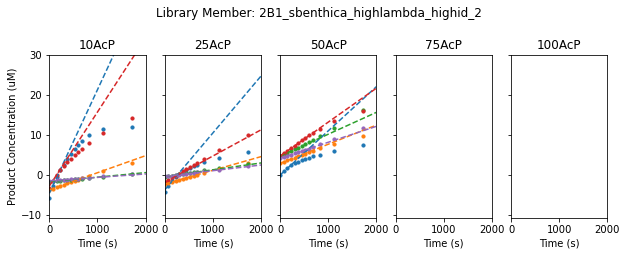

In [22]:
sq_merged = processing.get_initial_rates(sq_merged, pbp_conc=30)

# Michaelis-Menten curve fitting

To perform the fitting, we apply another "squeeze" to create columns for the substrate concentration series and initial rate series. Scale initial rates by enzyme concentration. If there is no measurement for a zero substrate condition, a zero placeholder is added to the beginning of the substrate conc and initial rate lists.

Fitting Michaelis-Menten curves...


Done fitting Michaelis-Menten curves.
Plotting examples...


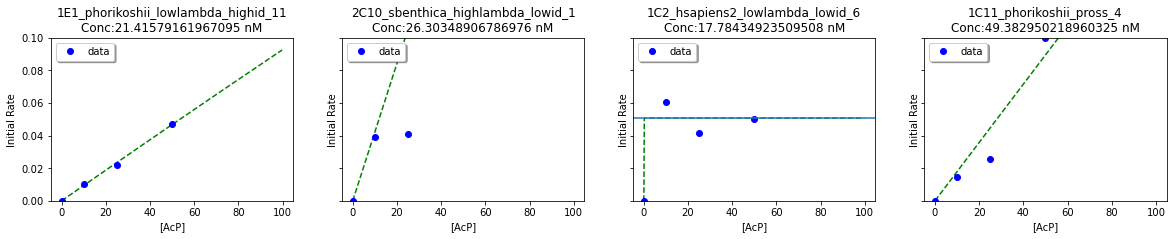

In [23]:
squeeze_mm = processing.fit_michaelis_menten(sq_merged, exclude_concs=[75, 100])

# Inhibition 

In [24]:
# constant substrate concentration with increasing inhibitor concentration
# should be similar to unfolding curves (normalize to 0uM inhibitor and plot y axis in linear scale)

# Calculate local background ratio
Add as a row in the by-chamber, by-substrate concentration dataframe, then squeeze into a list in the MM dataframe 

Next, iterate row-wise across the dataframe and compute the local background ratio. This algorithm is as follows: 
    1. for each chamber, store the intial rate for the highest substrate concentration condition
    2. coerce all rates below 0.00001 to zero
    3. store the rates in the above and below chambers
        2.1. 
        2.2. average rates

In [25]:
squeeze_mm, sq_merged = processing.calculate_local_bg_ratio(squeeze_mm, sq_merged, device_rows=device_rows, exclude_concs=[100, 75])
squeeze_mm.head(5)

/Users/micaholivas/Desktop/htmek_processing/experiment_processing/processing.py:923: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  local_bg_df['index_tuple'] = local_bg_df.apply(lambda row: (row.x, row.y), axis=1)


,x,y,Indices,MutantID,substrate,EnzymeConc,egfp_manual_flag,substrate_concs,initial_rates,KM_fit,vmax_fit,kcat_fit,kcat_over_KM_fit,local_bg_ratio
0,1,1,"01,01",1C8_phorikoshii_pross_2,AcP,27.811985,False,"[0, 10, 25, 50]","[0, 0.00566666666666666, 0.01161666666666666, ...",34794.984199,37.503411,1348.462206,38754.499748,32.383420
1,1,2,"01,02",BLANK,AcP,0.102914,False,"[0, 10, 25, 50]","[0, 0.0005666666666666598, 0.00084999999999999...",1434.404567,0.056495,548.952204,382703.887855,0.059910
2,1,3,"01,03",2A4_sbenthica_lowlambda_highid_7,AcP,46.614042,False,"[0, 10, 25, 50]","[0, 0.0011333333333333336, 0.00113333333333334...",15.696998,0.002351,0.050438,3213.228442,0.536111
3,1,4,"01,04",BLANK,AcP,0.597261,False,"[0, 10, 25, 50]","[0, 0.0016999999999999958, 0.00226666666666666...",626.856264,0.070100,117.369586,187235.244198,0.220088
4,1,5,"01,05",1G1_phorikoshii_lowlambda_lowid_8,AcP,39.964596,False,"[0, 10, 25, 50]","[0, 0.004816666666666672, 0.011050000000000003...",23211.631826,18.905568,473.057911,20380.209155,8.148936


# Print PDFs

Generate one experiment-level summary PDF and one PDF per chamber with the following plots:
1. **Progress curves** for each substrate condition with linear initial rate fits
2. **Standard curve** 
4. **Michaelis-Menten fits** to each substrate condition

PDFs are exported to a `PDF` directory in the specified export directory.

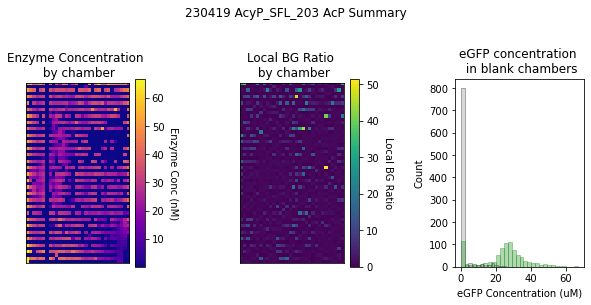

Export complete: 100%|██████████| 1792/1792 [30:40<00:00,  1.03s/it]      


In [28]:
processing.plot_chip_summary(squeeze_mm=squeeze_mm, sq_merged=sq_merged, squeeze_standards=squeeze_standards, squeeze_kinetics=squeeze_kinetics, button_stamps=button_stamps, device_columns=device_columns, device_rows=device_rows, export_path_root=export_path_root, experimental_day=experimental_day, experiment_name=experiment_name, pbp_conc=pbp_conc, exclude_concs=[], substrate=substrate)

#### Merge PDFs

In [26]:
processing.merge_pdfs(export_path_root=export_path_root, substrate=substrate, experimental_day=experimental_day)

Merging PDFs:  52%|█████▏    | 288/557 [00:00<00:00, 364.63it/s]


OSError: [Errno 22] Invalid argument

# Export Data

In [27]:
processing.export_data(sq_merged, squeeze_mm, export_path_root, experimental_day, setup, device, substrate=substrate, experiment_name=experiment_name)